# 第5部　正規線形モデル｜Pythonで学ぶ統計学入門

## 2章　分散分析

この章では、分散分析の理論とPythonを用いた実装の方法を解説する。

分散分析は正規線形モデルにおいて幅広く用いられる検定手法。古典的な一元配置分散分析の説明の後、正規線形モデルにおける分散分析の位置付けを説明する。

### 2-1 この章の例題

応答変数として売上を、説明変数として天気のみを用いる。
天気は曇り・雨・晴れという3つの水準を持つ。古典的な用語でいうと一元配置分散分析と呼ばれる手法。
天気によって、売上が変化するといえるかどうかをこれから検定する。

### 2-2 分散分析が必要になるタイミング

* 分散分析は平均値の差を検定する手法
* 分散分析は母集団が正規分布に従うデータに対してのみ適用可能で、水準の間で分散の値が異ならないという条件を満たさなければならない
* 平均値の差の検定といえば、t検定だが、単純なt検定が適用できない場面がある
    * $t$検定は「薬を飲む前と飲んだ後」といったように**2つの水準間における平均値の差を検定**
    * 分散分析は「晴れor雨or曇りと天気が変わることによって売上が変化すると言えるかどうか」といったように3つ以上の水準をもつデータが対象
* 正規線形モデルの枠組みでみると幅広い対象に適用が可能となる（後述）
    
### 2-3 検定の多重性

検定を繰り返すことで有意な結果が得られやすくなってしまう問題を**検定の多重性**と呼ばれる。

有意水準を0.05と定めて検定を行ったとする。第一種の過誤を犯す確率は5%。
検定を2回続けて行い、「少なくともどちらか片方の検定において帰無仮説を棄却できれば対立仮説を採用する」というルールで検定を行ったとする。
すると、第一種の過誤を犯す確率は「$1-(0.95 \times 0.95) = 0.0975$」となり、ほぼ10%となる。検定を繰り返すことによって、帰無仮説が棄却されやすくなる。

例えば、晴れor雨or曇りという3つの水準で売上が異なるかを検定する際に「晴れVS雨」「雨VS曇り」「晴れVS曇り」の3つの組み合わせにおいて$t$検定を行うと、検定の多重性の問題が生じる。一方、分散分析だと晴れとか雨とかいった個別のカテゴリを見るのではなく、「天気によってビールの売上が異なるかどうか」を一度の検定で判断することができるようになる。

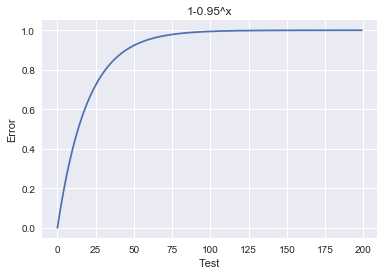

In [5]:
plt.plot(range(200), [1-.95**x for x in range(200)])
plt.xlabel('Test')
plt.ylabel('Error')
plt.title('1-0.95^x')

### 2-4 分散分析の直感的な考え方：F比

分散分析の帰無仮説と対立仮説は以下の通り。

* 帰無仮説：水準間で平均値に差はない
* 対立仮説：水準間で平均値に差がある

分散分析では、データの変動を「誤差」と「効果」に分離し、F比と呼ばれる統計量を計算する

$$F比 = \frac{効果の分散の大きさ}{誤差の分散の大きさ}$$

* 効果：「天気がもたらす売上の変動」　→　「天気が変わることによるデータのばらつきの大きさ」
* 誤差：「天気という変数を用いて説明することができなかった、ビールの売上の変動」　→　「残差の分散」

分散の比をとって統計量として検定を行うことから分散分析やANOVA（ANalysis Of VAiance）とも呼ばれる。

F比が大きければ、誤差に比べて効果の影響が大きいと判断できる。母集団分布が等分散正規分布であるときのF比の標本分布はすでに明らかになっていて、**F分布**と呼ばれる。
F分布の累積分布関数を用いて$p$値を計算し、$p$値が0.05以下となった場合に帰無仮説を棄却するという流れは$t$検定と同様。

### 2-5 有意差が出るときと出ないときのバイオリンプロット

分散分析という検定手法のイメージをつかんでいただくために、有意差が出るときと出ないときのデータの特徴を確認していく。
図2−1は「明らかに有意差があると判断できるとき」のバイオリンプロット。図2−2は、有意差が得られないデータのバイオリンプロット。
グラフをみただけで有意差の判断ができそうだが、定量的な基準を用いた判断を試みる場合には分散分析が必要。

<img src="violin_plot.png" width="400">

<img src="violin_plot2.png" width="400">

### 2-6 分散分析の直感的な考え方：誤差と効果の分離

誤差の大きさ、効果の大きさというものに対して、図を用いた直感的な解釈を試みる。

<img src="violin_plot_description.png" width="400">

各々のバイオリンは天気という水準ごとに分かれている。

* バイオリン同士が離れていること　→　「天気の効果の大きさ」（F比の分子）
* バイオリン単体の幅　→　「誤差の大きさ」（F比の分母）


### 2-7 群間変動・群内変動

* **群間変動**：バイオリン同士の距離、すなわち効果の大きさのこと
* **群内変動**：各々のバイオリンの幅、すなわち誤差の大きさのこと

分散分析では、データのぶんさんを↑のふたつに分けた上で、その比をとり、統計量として検定を行う。

### 分析の準備

Pythonを使って分散分析を実装していく。

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ(ワーニングが出ることもあります)
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 表示桁数の指定
%precision 3
# グラフをjupyter Notebook内に表示させるための指定
%matplotlib inline

/Users/kaito/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### データの作成と表示

今回は計算結果を見やすくするために、あえて小さなデータを対象とする

In [2]:
# サンプルデータの作成
weather = [
    "cloudy","cloudy",
    "rainy","rainy",
    "sunny","sunny"
]
beer = [6,8,2,4,10,12]

# データフレームにまとめる
weather_beer = pd.DataFrame({
    "beer"   : beer,
    "weather": weather
})
print(weather_beer)

   beer weather
0     6  cloudy
1     8  cloudy
2     2   rainy
3     4   rainy
4    10   sunny
5    12   sunny


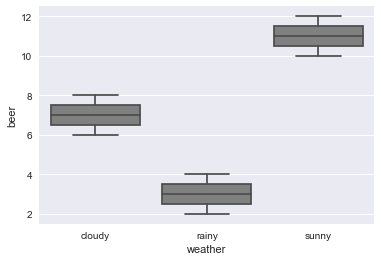

In [4]:
# サンプルサイズが小さいのでバイオリンプロットではなく、箱髭図を描く
sns.boxplot(x = "weather",y = "beer",
            data = weather_beer, color='gray')

天気ごとの売上の平均値を計算する。雨の日は売上が少なく、晴れの日は多く、曇の日はその中間であることがわかる。

In [5]:
# 各データの平均値
print(weather_beer.groupby("weather").mean())

         beer
weather      
cloudy      7
rainy       3
sunny      11


### 実装：分散分析①群間・群内平方和の計算

最初はパッケージを使わないで一元配置分散分析を実装してみる。

まずは効果の大きさ、すなわち群間変動から計算する。

天気毎の売上の平均値はすでに計算済みで、例えば曇りの日の売上の平均値は7。ここで、「天気が曇りになることによって売上は7万円になると期待できる」と考える。他も同様に雨の日は3万円、晴れの日は11万円になると考える。

すると、曇りの日も雨の日も晴れの日も2日ずつあるので、天気による影響だけを考えた場合の売上は以下のようになると期待される。

In [6]:
# 天気の持つ影響
effect = [7,7,3,3,11,11]

このeffectのばらつきの大きさを求めることで、群間変動を得ることができる。
群間変動の分子に当たる群間の偏差平方和を計算する。

In [7]:
# 群間の平方和
mu_effect = sp.mean(effect)
squares_model = sp.sum((effect - mu_effect) ** 2 )
squares_model

64.000

一方、誤差は元データから効果を引くことによって計算される。

In [8]:
# 天気では説明することができない誤差
resid = weather_beer.beer - effect
resid

0   -1
1    1
2   -1
3    1
4   -1
5    1
Name: beer, dtype: int64

こちらも同じく群内の偏差平方和を求める。
誤差の平均値は0であることに注意。

In [9]:
# 群内の平方和
squares_resid = sp.sum(resid ** 2)
squares_resid

6

### 実装：分散分析②群間・群内分散の計算

不偏分散を計算するときにサンプルサイズで割らず、−1したように、
分散分析でも、群間・群内の分散を計算する際の分母は単なるサンプルサイズにならず、自由度と呼ばれるもので割る。

群間変動の自由度は、水準の種類数に左右される。
今回は曇り・雨・晴れの3種類の水準があったので、そこから1を引いて、群間変動の自由度は2となる。

郡内変動の自由度は、サンプルサイズと水準の種類数に左右される。
今回はサンプルサイズが6で、水準が3種類あったので、6-3=3が郡内変動の自由度となる。

In [10]:
df_model = 2 # 群間変動の自由度
df_resid = 3 # 群内変動の自由度

In [11]:
# 群間の平均平方(分散)
variance_model = squares_model / df_model
variance_model

32.000

In [12]:
# 群内の平均平方(分散)
variance_resid = squares_resid / df_resid
variance_resid

2.000

### 実装：分散分析③p値の計算

最後に$F$比と$p$値を計算する。
F比は、以下のように計算される。

$$F比 = \frac{効果の分散の大きさ}{誤差の分散の大きさ}$$

In [13]:
# F比
f_ratio = variance_model / variance_resid
f_ratio

16.000

$p$値は$F$分布の累積分布関数から計算することができる。`sp.stats.f.cdf`関数を使う。
引数には$F$比と2つの自由度を指定する。

In [14]:
# p値
1 - sp.stats.f.cdf(x = f_ratio, dfn = df_model, dfd = df_resid)

0.025

$p$値が0.05以下となった。
ここで、分散分析の帰無仮説と対立仮説は以下の通りなので、天気によって売上は有意に変化すると判断できる。

* 帰無仮説：水準間で平均値に差はない
* 対立仮説：水準間で平均値に差がある

以上が一元配置分散分析の計算方法。

※ 本来はサンプルサイズがもっと大きなデータに対して適用するべきであることに注意。

### 2-13 説明変数がカテゴリ型である正規線形モデル

続いて、正規線形モデルという枠組みから分散分析を解釈していく。

天気から売上を予測する正規線形モデルは以下のようになる。

$$ビールの売上\ \tilde \ \ \ \ \cal{N}(\beta_0 + \beta_1 \times 雨 + \beta_2 \times 晴\ ,\ \sigma^2)$$

ここで「雨」とは天気が雨だったときに1を、それ以外の日には0をとる変数とする。「晴」も同様。
$\beta_1$は雨の影響を表すパラメータ、$\beta_2$は晴れの影響を表すパラメータ。
雨でも晴れでもない場合は、$\beta_0$だけが残るので、これが曇りの係数と解釈する。

### 2-14 ダミー変数

先程の「雨」、「晴」のように雨の日あるいは晴れの日は1、それ以外は0の値をとる変数をダミー変数と呼ぶ。

### 実装：statsmodelsによる分散分析

一元配置分散分析を行ったデータを、正規線形モデルの枠組みでモデル化する。

カテゴリ型の変数であっても`smf.ols`関数を使ってモデル化することができる。

In [15]:
# 正規線形モデルの構築
anova_model = smf.ols("beer ~ weather", 
                      data = weather_beer).fit()

`sm.stats.anova_lm`関数を用いて分散分析を実行することができる。「`typ=2`」とした意味は次章で解説。

In [16]:
# 分散分析の結果
print(sm.stats.anova_lm(anova_model, typ=2))

          sum_sq   df     F    PR(>F)
weather     64.0  2.0  16.0  0.025095
Residual     6.0  3.0   NaN       NaN


### 2-16 分散分析表

`sm.stats.anova_lm`関数で出力された形式の↑の表を**分散分析表**と呼ぶ。

分散分析表には、群間・群内の偏差平方和`sum_sq`、自由度`df`、そして$F$比と$p$値がまとめられている。

### モデルの係数の解釈

In [17]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

推定されたモデルの係数は↑のようになる。

$$ビールの売上\ \tilde \ \ \ \ \cal{N}(\beta_0 + \beta_1 \times 雨 + \beta_2 \times 晴\ ,\ \sigma^2)$$

Interceptは$\beta_0$に対応する。これは曇りの日の売上の平均は7になるということを意味している。
雨の日には係数`weather[T.rainy]`が加わるので7-4=3となる。
晴れの日は逆に4を足すことになるので、晴れの日の売上の期待値は11となる。

### モデルを用いて誤差と効果を分離する

推定されたモデルの係数を用いて、訓練データに対する当てはめ結果を見てみましょう。

In [18]:
#当てはめ値
fitted = anova_model.fittedvalues
fitted

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

この当てはめ結果は、各水準の平均値と一致する。
説明変数をカテゴリ型の変数にした正規線形モデルの推測値は、各水準の平均値と一致する。

残差は以下のように取得できる。
これら2つを使うことで分散分析を行うことができるが、計算は省略。

In [19]:
# 残差
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

### 回帰モデルにおける分散分析

分散分析は、説明変数にカテゴリ型変数を使おうが、連続型変数を使おうが、正規線形モデルにおいて一般的に用いることができる。

第1章と同じモデルを再度計算する。

In [20]:
# データの読み込み
beer = pd.read_csv("5-1-1-beer.csv")

# モデルの推定
lm_model = smf.ols(formula = "beer ~ temperature", 
                   data = beer).fit()

説明変数が連続型のデータの場合は、群間変動や郡内変動といった用語はあまり使われない。

ここでは、群間変動の自由度を<u>モデルの自由度</u>、群内変動の自由度を<u>残差の自由度</u>と呼ぶことにする。

モデルの自由度は、推定されたパラメータの数から1を引いたもので、単回帰モデルの係数は切片と傾きの2つなのでモデルの自由度は1となる。

残差の自由度は、サンプルサイズから推定されたパラメータ数を引いたもので、30-2=28となる。

In [21]:
df_lm_model = 1  # モデルの自由度
df_lm_resid = 28 # 残差の自由度

$F$比を計算する。

In [22]:
# 当てはめ値
lm_effect = lm_model.fittedvalues
# 残差
lm_resid = lm_model.resid
# 気温の持つ効果の大きさ
mu = sp.mean(lm_effect)
squares_lm_model = sp.sum((lm_effect - mu) ** 2)
variance_lm_model = squares_lm_model / df_lm_model
# 残差の大きさ
squares_lm_resid = sp.sum((lm_resid) ** 2)
variance_lm_resid = squares_lm_resid / df_lm_resid
# F比
f_value_lm = variance_lm_model / variance_lm_resid
f_value_lm

28.447

この$F$比を用いて$p$値を計算してもいいけど、桁落ちでほぼ0となる。

In [23]:
# 参考：p値(桁落ちで0になる)
1 - sp.stats.f.cdf(
    x=f_value_lm,dfn=df_lm_model,dfd=df_lm_resid)

0.000

`sm.stats.anova_lm`関数で分散分析表を出力して、$F$比の計算結果が一致していることを確認。

In [24]:
# 分散分析表
print(sm.stats.anova_lm(lm_model, typ=2))

                  sum_sq    df          F    PR(>F)
temperature  1651.532489   1.0  28.446984  0.000011
Residual     1625.582178  28.0        NaN       NaN


この結果の一部は、モデルのsummaryにも出力されている。

出力の最上段にあるF-statisticが$F$比を、Prob(F-statistic)が分散分析の$p$値を表している。


なお、説明変数が1つだけの場合は、係数の$t$検定の結果と分散分析の結果は一致する。説明変数が増えると一致しない。

In [40]:
# モデルのsummary
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Fri, 28 Dec 2018   Prob (F-statistic):           1.11e-05
Time:                        16:54:42   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""